# Exploratory Data Analysis (EDA) of OpenML Datasets

This notebook presents an exploratory data analysis of datasets from OpenML. We will examine dataset descriptions, analyze word and sentence lengths, perform named entity recognition, POS tagging, and explore text similarity among dataset descriptions. We will also investigate the complexity of dataset descriptions, the distribution of tags, and the number of features in datasets. Finally, we will analyze the presence of URLs in dataset descriptions and explore the domains of these URLs.

In [1]:
import openml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
from tqdm import tqdm
import nltk
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud, STOPWORDS
from urlextract import URLExtract
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from spacy import displacy
import plotly.express as px
import textstat
from collections import defaultdict
from urllib.parse import urlparse

# Enable GPU support for spaCy
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# spacy must be imported after setting the environment variable
import spacy

activated = spacy.prefer_gpu()

try:
    nlp = spacy.load("en_core_web_trf")
except OSError:
    !python -m spacy download en_core_web_trf
    nlp = spacy.load("en_core_web_trf")

# Disable truncation in pandas display of columns
pd.set_option('display.max_colwidth', None)

# Disable truncation in pandas display of rows 
# pd.set_option('display.max_rows', None)

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.11/site-packages/textstat/textstat.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Data Retrieval
Retrieving and listing all datasets from OpenML.

In [2]:
datasets = openml.datasets.list_datasets()
print(openml.datasets.list_datasets()[531])

ids = list(datasets.keys())
print("Number of datasets: ", len(ids))

# Removing non-dataset entries 
ids.remove(4537)
ids.remove(4546)
ids.remove(4562)

# Fetching datasets
datasets = openml.datasets.get_datasets(ids, download_data=False, download_qualities=False)
datasets[0]

/var/folders/cl/69z7wmcn5xx7cb7wc_xvd8fw0000gn/T/ipykernel_1758/2888816978.py:1: FutureWarning: Support for `output_format` of 'dict' will be removed in 0.15 and pandas dataframes will be returned instead. To ensure your code will continue to work, use `output_format`='dataframe'.
  datasets = openml.datasets.list_datasets()
/var/folders/cl/69z7wmcn5xx7cb7wc_xvd8fw0000gn/T/ipykernel_1758/2888816978.py:2: FutureWarning: Support for `output_format` of 'dict' will be removed in 0.15 and pandas dataframes will be returned instead. To ensure your code will continue to work, use `output_format`='dataframe'.
  print(openml.datasets.list_datasets()[531])


{'did': 531, 'name': 'boston', 'version': 1, 'uploader': '2', 'status': 'active', 'format': 'ARFF', 'MaxNominalAttDistinctValues': 9.0, 'NumberOfClasses': 0.0, 'NumberOfFeatures': 14.0, 'NumberOfInstances': 506.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 12.0, 'NumberOfSymbolicFeatures': 2.0}
Number of datasets:  5448


/Users/ivang/miniconda3/envs/openml-tags/lib/python3.11/site-packages/openml/datasets/functions.py:447: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  get_dataset(dataset_id, download_data, download_qualities=download_qualities),


OpenML Dataset
Name.........: anneal
Version......: 1
Format.......: ARFF
Upload Date..: 2014-04-06 23:19:24
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/1666876/anneal.arff
OpenML URL...: https://www.openml.org/d/2
# of features: 39

## Initial Dataframe Creation
Creation of an initial dataframe for analysis, including URLs and descriptions.

In [3]:
df = pd.DataFrame([dataset.__dict__ for dataset in datasets])
# Add the OpenML URL to the dataframe
df['openml_url'] = [dataset.openml_url for dataset in datasets]
# All datasets which have None description, make it an empty string "
df['description'] = df['description'].fillna('')
# Remove datasets with identical descriptions
# df = df.drop_duplicates(subset='description')
df

ignore_attribute  dataset_id             name  version  \
0                None           2           anneal        1   
1                None           3         kr-vs-kp        1   
2                None           4            labor        1   
3                None           5       arrhythmia        1   
4                None           6           letter        1   
...               ...         ...              ...      ...   
5440             None       45930  AutoDescDataset        1   
5441             None       45932              RCM        2   
5442             None       45933    HousingPrices        1   
5443             None       45934    HousingPrices        2   
5444             None       45935       FX-CAD-USD        1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5445 entries, 0 to 5444
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ignore_attribute          313 non-null    object
 1   dataset_id                5445 non-null   int64 
 2   name                      5445 non-null   object
 3   version                   5445 non-null   int64 
 4   description               5445 non-null   object
 5   cache_format              5445 non-null   object
 6   format                    5445 non-null   object
 7   creator                   3187 non-null   object
 8   contributor               752 non-null    object
 9   collection_date           3495 non-null   object
 10  upload_date               5445 non-null   object
 11  language                  1820 non-null   object
 12  licence                   5445 non-null   object
 13  url                       5445 non-null   object
 14  default_target_attribute

## Description Length Analysis

Analyzing the length of dataset descriptions.

<Axes: >

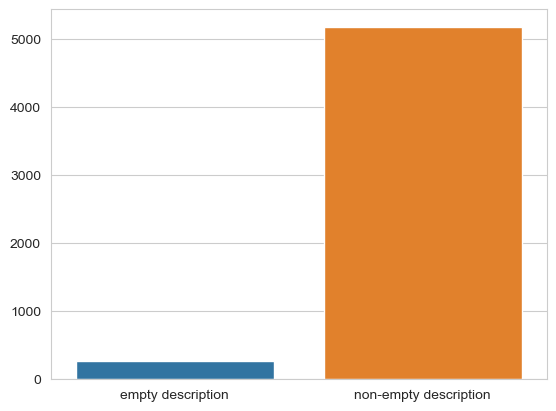

In [5]:
sns.barplot(x=['empty description', 'non-empty description'],
            y=[len(df[df['description'] == '']), len(df[df['description'] != ''])],
            hue=['empty description', 'non-empty description'])

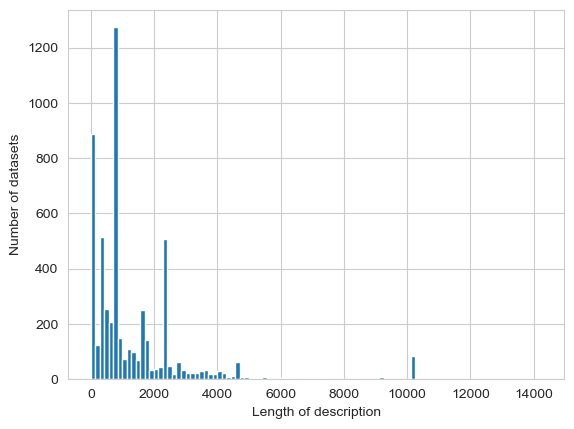

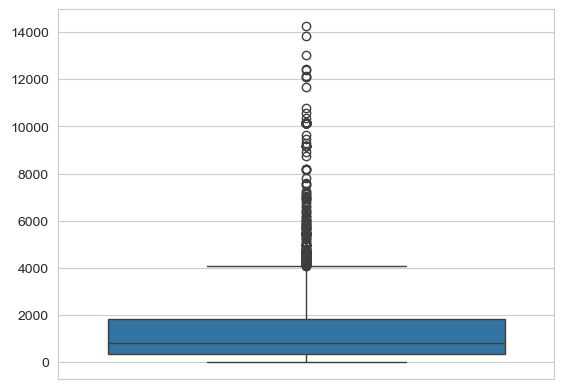

In [6]:
plt.hist([len(d) for d in df['description']], bins=100, color='C0')
plt.xlabel('Length of description')
plt.ylabel('Number of datasets')
plt.show()

sns.boxplot([len(d) for d in df['description']], color='C0')
plt.show()

## Filtering Long Descriptions

Filtering out datasets with unusually long descriptions for further inspection.

In [7]:
df[df['description'].map(len) > 9000]

ignore_attribute  dataset_id  \
41               None          49   
43               None          51   
139              None         204   
163              None         231   
383         [country]         528   
...               ...         ...   
5265             None       45532   
5266             None       45533   
5267             None       45534   
5268             None       45535   
5287             None       45562   

                                                         name  version  \
41                                                    heart-c        1   
43                                                    heart-h        1   
139                                               cholesterol        1   
163                                                 hungarian        1   
383                                                humandevel        1   
...                                                       ...      ...   
5265  timing-attack-dataset-35-micro-seconds-delay-2022-09-18        1   
5266  timing-attack-dataset-35-micro-seconds-delay-2022-09-19        1   
5267  timing-attack-dataset-35-micro-seconds-delay-2022-09-20        1   
5268  timing-attack-dataset-35-micro-seconds-delay-2022-09-21        1   
5287                                            seismic-bumps        3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

## Word and Sentence Analysis

Analyzing the word count and average sentence length in dataset descriptions.

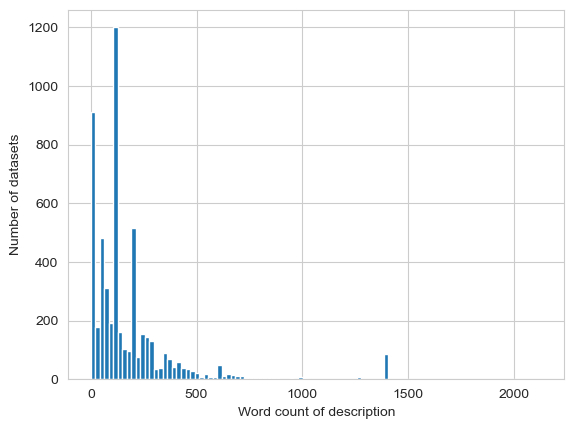

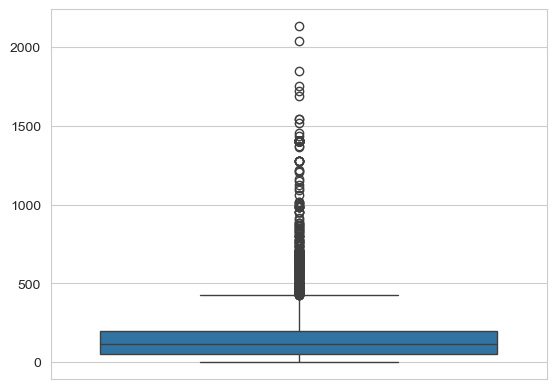

In [8]:
# Word count analysis
plt.hist([len(d.split()) for d in df['description']], bins=100, color='C0')
plt.xlabel('Word count of description')
plt.ylabel('Number of datasets')
plt.show()

sns.boxplot([len(d.split()) for d in df['description']], color='C0')
plt.show()

[nltk_data] Downloading package punkt to /Users/ivang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


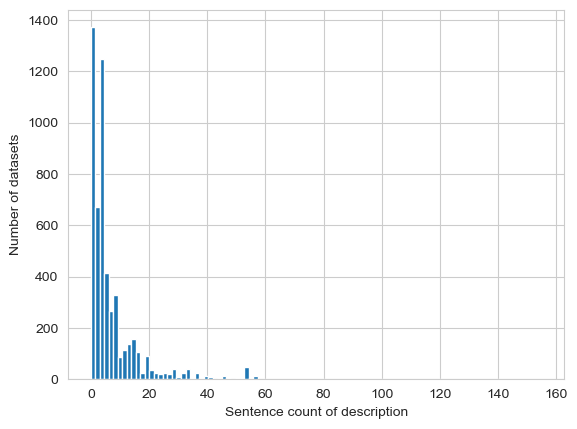

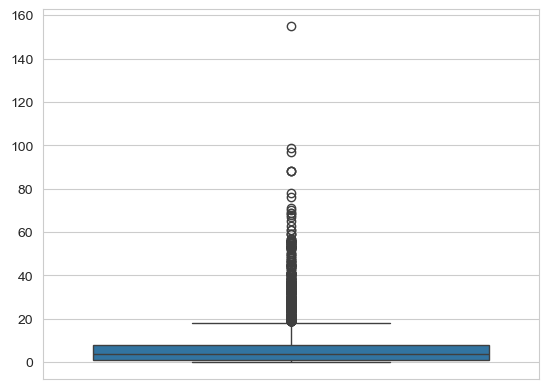

In [9]:
# Sentence length analysis 
import nltk
from nltk import tokenize

nltk.download('punkt')

plt.hist([len(tokenize.sent_tokenize(d)) for d in df['description']], bins=100, color='C0')
plt.xlabel('Sentence count of description')
plt.ylabel('Number of datasets')
plt.show()

sns.boxplot([len(tokenize.sent_tokenize(d)) for d in df['description']], color='C0')
plt.show()

## Mean Word Length Calculation

Computing the mean word length in dataset descriptions using spaCy for more accurate tokenization.

In [10]:
# Function to calculate mean word length
def mean_word_length(description):
    doc = nlp(description)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    if words:  # Check if there are words to avoid ZeroDivisionError
        return sum(len(word) for word in words) / len(words)
    else:
        return 0


mean_word_lengths = df['description'].apply(mean_word_length)
print("Mean word lengths mean and median: ", mean_word_lengths.mean(), mean_word_lengths.median())

Mean word lengths mean and median:  7.195858817021143 5.556521739130435


Average word length in English texts is 5.1 characters


## Visualization of Mean Word Lengths

Displaying the distribution of mean word lengths across dataset descriptions.

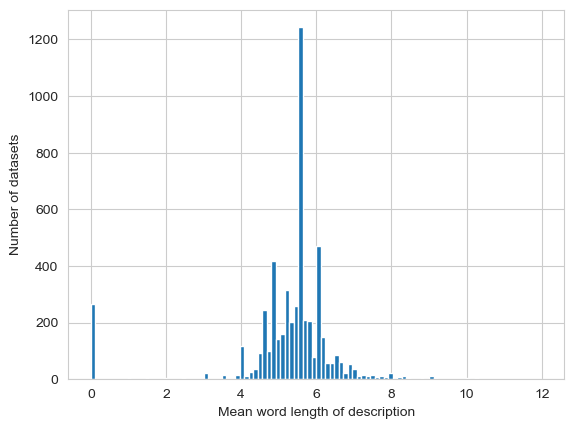

In [11]:
plt.hist(mean_word_lengths, bins=100, color='C0', range=(0, 12))
plt.xlabel('Mean word length of description')
plt.ylabel('Number of datasets')
plt.show()

## Longest Word in Descriptions

Identifying the longest words within dataset descriptions.

In [12]:
def longest_word(description):
    doc = nlp(description)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    if words:  # Check if there are words to avoid ZeroDivisionError
        return max(words, key=len)
    else:
        return None


longest_words = df['description'].apply(longest_word)
longest_words.value_counts().head(10)

description
MOLECULE_CHEMBL_ID                                                 1083
list(x.columns[sorted_column_idxs                                   436
classifying                                                         231
https://www.dukascopy.com/swiss/english/marketwatch/historical/     192
https://github.com/LeoGrin/tabular-benchmark                        150
Acknowledgements                                                    116
Correctly_formatted_PKCS#1_PMS_message__but_1_byte_shorter           87
test                                                                 85
classification                                                       83
fri_colinearintydegree_samplenumber_featurenumber                    80
Name: count, dtype: int64

## Term Frequency Analysis

Performing term frequency analysis to identify the most common words and phrases in dataset descriptions, excluding common stopwords.

[nltk_data] Downloading package stopwords to /Users/ivang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


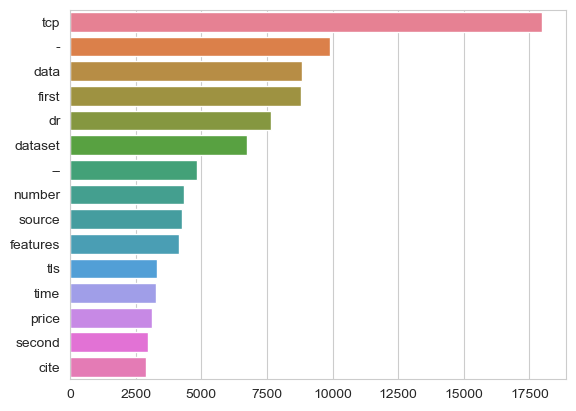

In [13]:
nltk.download('stopwords')

# Function to clean and preprocess text
def clean(text, remove_stopwords=True, remove_numbers=True):
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    # Remove stopwords
    if remove_stopwords:
        text = ' '.join([word for word in word_tokenize(text) if word not in stopwords.words('english')])
    # Remove numbers too
    if remove_numbers:
        text = re.sub(r'\d+', '', text)

    return text

# Term frequency analysis for single words
mostCommon = Counter(word_tokenize(" ".join(df['description'].map(clean)))).most_common(15)
words = [word[0] for word in mostCommon]
frequency = [word[1] for word in mostCommon]

sns.barplot(x=frequency, y=words, hue=words)
plt.show()

## Topics Bar Chart
![Topics Bar Chart](latex/proposal/images/topics_barchart.png)

## Bigram Frequency Analysis

Analyzing the frequency of bigrams (pairs of words) in dataset descriptions.

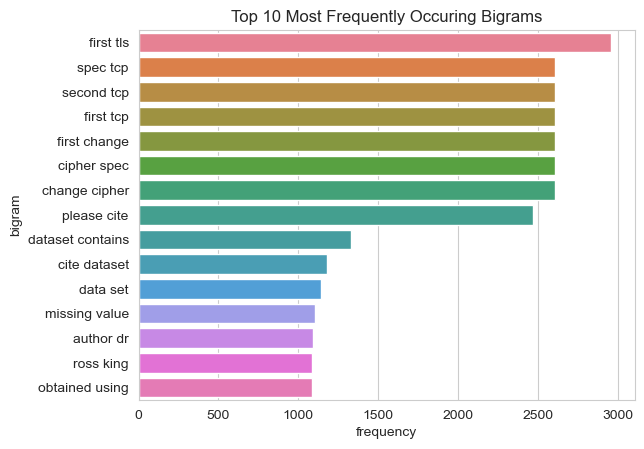

In [14]:
cv = CountVectorizer(ngram_range=(2, 2))
bigrams = cv.fit_transform(df['description'].map(clean))

count_values = bigrams.toarray().sum(axis=0)
bigram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
bigram_freq.columns = ["frequency", "bigram"]

sns.barplot(x=bigram_freq['frequency'][:15], y=bigram_freq['bigram'][:15], hue=bigram_freq['bigram'][:15])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Datasets Containing Specific Keywords

Filtering datasets that contain specific keywords such as 'TCP' within their descriptions.

In [15]:
df[df['description'].map(lambda x: 'tcp' in x)].head(50)

ignore_attribute  dataset_id  \
941              None        1110   
944              None        1113   
3233             None       42746   
5182             None       45449   
5183             None       45450   
5184             None       45451   
5185             None       45452   
5186             None       45453   
5187             None       45454   
5188             None       45455   
5189             None       45456   
5190             None       45457   
5191             None       45458   
5192             None       45459   
5193             None       45460   
5194             None       45461   
5195             None       45462   
5196             None       45463   
5197             None       45464   
5198             None       45465   
5199             None       45466   
5200             None       45467   
5201             None       45468   
5202             None       45469   
5203             None       45470   
5204             None       45471   
5205             None       45472   
5206             None       45473   
5207             None       45474   
5208             None       45475   
5209             None       45476   
5210             None       45477   
5211             None       45478   
5212             None       45479   
5213             None       45480   
5214             None       45481   
5215             None       45482   
5216             None       45483   
5217             None       45484   
5218             None       45485   
5219             None       45486   
5220             None       45487   
5221             None       45488   
5222             None       45489   
5223             None       45490   
5224             None       45491   
5225             None       45492   
5226             None       45493   
5227             None       45494   
5228             None       45495   

                                                          name  version  \
941                                              KDDCup99_full        1   
944                                                   KDDCup99        1   
3233                                                  KDDCup99        5   
5182    timing-attack-dataset-1-micro-seconds-delay-2022-09-01        1   
5183    timing-attack-dataset-1-micro-seconds-delay-2022-09-12        1   
5184    timing-attack-dataset-1-micro-seconds-delay-2022-09-17        1   
5185    timing-attack-dataset-2-micro-seconds-delay-2022-09-01        1   
5186    timing-attack-dataset-2-micro-seconds-delay-2022-09-12        1   
5187    timing-attack-dataset-2-micro-seconds-delay-2022-09-17        1   
5188    timing-attack-dataset-4-micro-seconds-delay-2022-09-01        1   
5189    timing-attack-dataset-4-micro-seconds-delay-2022-09-12        1   
5190    timing-attack-dataset-4-micro-seconds-delay-2022-09-17        1   
5191    timing-attack-dataset-8-micro-seconds-delay-2022-09-01        1   
5192    timing-attack-dataset-8-micro-seconds-delay-2022-09-12        1   
5193    timing-attack-dataset-8-micro-seconds-delay-2022-09-17        1   
5194   timing-attack-dataset-16-micro-seconds-delay-2022-09-01        1   
5195   timing-attack-dataset-16-micro-seconds-delay-2022-09-12        1   
5196   timing-attack-dataset-16-micro-seconds-delay-2022-09-17        1   
5197   timing-attack-dataset-32-micro-seconds-delay-2022-09-01        1   
5198   timing-attack-dataset-32-micro-seconds-delay-2022-09-12        1   
5199   timing-attack-dataset-32-micro-seconds-delay-2022-09-17        1   
5200   timing-attack-dataset-64-micro-seconds-delay-2022-09-01        1   
5201   timing-attack-dataset-64-micro-seconds-delay-2022-09-12        1   
5202   timing-attack-dataset-64-micro-seconds-delay-2022-09-17        1   
5203  timing-attack-dataset-128-micro-seconds-delay-2022-09-01        1   
5204  timing-attack-dataset-128-micro-seconds-delay-2022-09-12        1   
5205  timing-attack-dataset-128-micro-seconds-delay-2022-09-17        1   
5206  timing-atta

## Trigram Frequency Analysis

Similar to bigram analysis, examining the frequency of trigrams (three-word sequences).

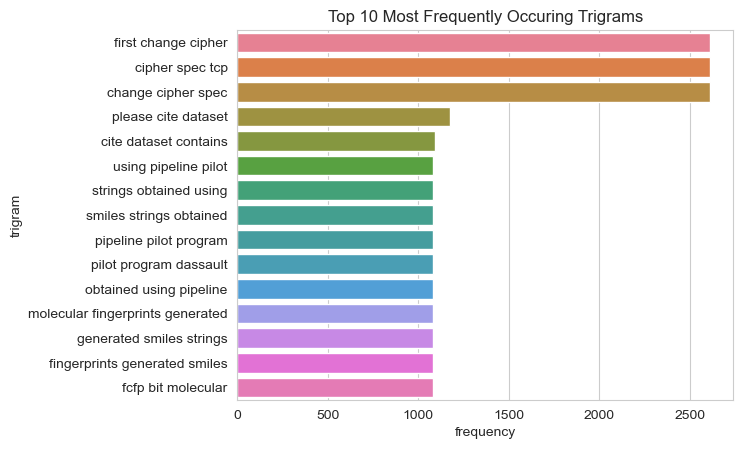

In [16]:
cv = CountVectorizer(ngram_range=(3, 3))
trigrams = cv.fit_transform(df['description'].map(clean))

count_values = trigrams.toarray().sum(axis=0)
trigram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
trigram_freq.columns = ["frequency", "trigram"]

sns.barplot(x=trigram_freq['frequency'][:15], y=trigram_freq['trigram'][:15], hue=trigram_freq['trigram'][:15])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

## Exploring Original Data URLs

Investigating the presence and domains of original data URLs in the dataset descriptions.

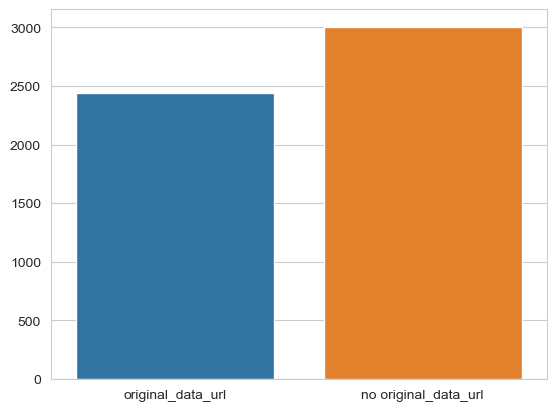

In [17]:
# Counting datasets with original data URLs
len(df[df['original_data_url'].notnull()])

# Visualization of datasets with and without original data URLs
sns.barplot(x=['original_data_url', 'no original_data_url'],
            y=[len(df[df['original_data_url'].notnull()]), len(df[df['original_data_url'].isnull()])],
            hue=['original_data_url', 'no original_data_url'])
plt.show()


## Domain Analysis of URLs

Analyzing the domains of URLs found in the descriptions and visualizing the top domains.

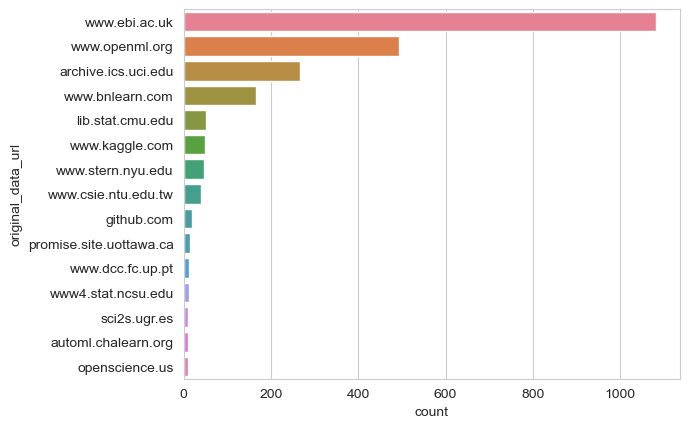

In [18]:
domains = (df['original_data_url'].dropna().map(lambda x: urlparse(x).netloc))

k = 15
sns.barplot(x=domains.value_counts().head(k), y=domains.value_counts().head(k).index,
            hue=domains.value_counts().head(k).index)
plt.show()


## Filtering Datasets by Domain

Filtering datasets with URLs from specific domains such as 'ebi.ac.uk' and 'github'.

In [19]:
df[df['original_data_url'].map(lambda x: 'ebi.ac.uk' in x if x else False)][
    ['name', 'original_data_url', 'openml_url']]

name                                       original_data_url  \
1277   QSAR-TID-12276  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3956   
1278   QSAR-TID-12475  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3848   
1279   QSAR-TID-12886  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL2731   
1280   QSAR-TID-10113  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL2978   
1281   QSAR-TID-12514   https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL319   
...               ...                                                     ...   
2354   QSAR-TID-30004  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3938   
2355   QSAR-TID-10803  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3187   
2356   QSAR-TID-12327  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3295   
2357   QSAR-TID-10962  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL2460   
2358  QSAR-TID-101276  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL5657   

                         openml_url  
1277  https://www.openml.org/d/3040  
1278  https://www.openml.org/d/3041  
1279  https://www.openml.org/d/3042  
1280  https://www.openml.org/d/3043  
1281  https://www.openml.org/d/3044  
...                             ...  
2354  https://www.openml.org/d/4127  
2355  https://www.openml.org/d/4128  
2356  https://www.openml.org/d/4129  
2357  https://www.openml.org/d/4130  
2358  https://www.openml.org/d/4131  

[1082 rows x 3 columns]

In [20]:
df[df['original_data_url'].map(lambda x: 'lib.stat.cmu' in x if x else False)][['name', 'original_data_url', 'openml_url']]

name                          original_data_url  \
313                      irish  http://lib.stat.cmu.edu/datasets/irish.ed   
332                      profb     http://lib.stat.cmu.edu/datasets/profb   
347                    papir_2          http://lib.stat.cmu.edu/datasets/   
348              colleges_aaup          http://lib.stat.cmu.edu/datasets/   
351                newton_hema          http://lib.stat.cmu.edu/datasets/   
365                    nflpass          http://lib.stat.cmu.edu/datasets/   
371              baseball-team          http://lib.stat.cmu.edu/datasets/   
377                       pm10          http://lib.stat.cmu.edu/datasets/   
392                     houses          http://lib.stat.cmu.edu/datasets/   
402                        no2          http://lib.stat.cmu.edu/datasets/   
403                    strikes          http://lib.stat.cmu.edu/datasets/   
406                    detroit          http://lib.stat.cmu.edu/datasets/   
407                     kidney          http://lib.stat.cmu.edu/datasets/   
521            chscase_census5          http://lib.stat.cmu.edu/datasets/   
522            chscase_census4          http://lib.stat.cmu.edu/datasets/   
523            chscase_census3          http://lib.stat.cmu.edu/datasets/   
524            chscase_census2          http://lib.stat.cmu.edu/datasets/   
525             chscase_demand          http://lib.stat.cmu.edu/datasets/   
526          visualizing_slope          http://lib.stat.cmu.edu/datasets/   
527      disclosure_x_tampered          http://lib.stat.cmu.edu/datasets/   
528  visualizing_environmental          http://lib.stat.cmu.edu/datasets/   
529           rmftsa_sleepdata          http://lib.stat.cmu.edu/datasets/   
530              chscase_funds          http://lib.stat.cmu.edu/datasets/   
531             hutsof99_logis          http://lib.stat.cmu.edu/datasets/   
532              sleuth_ex2016          http://lib.stat.cmu.edu/datasets/   
533              sleuth_ex2015          http://lib.stat.cmu.edu/datasets/   
534                   rabe_166          http://lib.stat.cmu.edu/datasets/   
535      visualizing_livestock          http://lib.stat.cmu.edu/datasets/   
536         rmftsa_ctoarrivals          http://lib.stat.cmu.edu/datasets/   
537              sleuth_ex1605          http://lib.stat.cmu.edu/datasets/   
538           visualizing_soil          http://lib.stat.cmu.edu/datasets/   
539              chscase_vine2          http://lib.stat.cmu.edu/datasets/   
540         visualizing_galaxy          http://lib.stat.cmu.edu/datasets/   
541              chscase_vine1          http://lib.stat.cmu.edu/datasets/   
542                   rabe_131          http://lib.stat.cmu.edu/datasets/   
543            diggle_table_a1          http://lib.stat.cmu.edu/datasets/   
544            diggle_table_a2          http://lib.stat.cmu.edu/datasets/   
546     hutsof99_child_witness          http://lib.stat.cmu.edu/datasets/   
547                    rabe_97          http://lib.stat.cmu.edu/datasets/   
548                   rabe_176          http://lib.stat.cmu.edu/datasets/   
549               disclosure_z          http://lib.stat.cmu.edu/datasets/   
551              sleuth_ex1221          http://lib.stat.cmu.edu/datasets/   
552               chscase_foot          http://lib.stat.cmu.edu/datasets/   
553         disclosure_x_noise          http://lib.stat.cmu.edu/datasets/   
554             chscase_health          http://lib.stat.cmu.edu/datasets/   
555            sleuth_case1202          http://lib.stat.cmu.edu/datasets/   
556            sleuth_case1201          http://lib.stat.cmu.edu/datasets/   
557        visualizing_hamster          http://lib.stat.cmu.edu/datasets/   
558          disclosure_x_bias          http://lib.stat.cmu.edu/datasets/   
559                   rabe_148          http://lib.stat.cmu.edu/datasets/   
560        visualizing_ethanol          http://lib.stat.cmu.edu/datasets/   
561            chscase

In [21]:
df[df['original_data_url'].map(lambda x: 'github' in x if x else False)][['name', 'original_data_url', 'openml_url']]


name  \
2509                 Fashion-MNIST   
2560                  freMTPL2freq   
2567                  okcupid-stem   
2845                MultilingualDS   
2878               Kuzushiji-MNIST   
2884                  Kuzushiji-49   
2947             article_influence   
2962                dating_profile   
3101                Midwest_Survey   
3102        Midwest_Survey_nominal   
3131                      penguins   
3190            ricci_vs_destefano   
3228                  okcupid-stem   
3242                Midwest_survey   
3256                Midwest_survey   
3257                Midwest_survey   
3450             ACSPublicCoverage   
3451             ACSPublicCoverage   
3452                     ACSIncome   
3455  StackOverflow-polarity-train   
3456   StackOverflow-polarity-test   
3457        StackOverflow-polarity   
3463        StackOverflow-polarity   
5010            MTPL_SHAP_Tutorial   
5180                     AfriSenti   

                                                                                                 original_data_url  \
2509                                                              https://github.com/zalandoresearch/fashion-mnist   
2560                                                                        https://github.com/dutangc/CASdatasets   
2567                                       https://github.com/rudeboybert/JSE_OkCupid/blob/master/profiles.csv.zip   
2845  https://github.com/valeriano-manassero/multilingual-text-categorization-dataset/blob/master/data/dataset.csv   
2878                                                                           https://github.com/rois-codh/kmnist   
2884                                                                           https://github.com/rois-codh/kmnist   
2947                     https://github.com/FlourishOA/Data/raw/master/estimated-article-influence-scores-2015.csv   
2962                                        https://github.com/rudeboybert/JSE_OkCupid/raw/master/profiles.csv.zip   
3101                                             https://github.com/fivethirtyeight/data/tree/master/region-survey   
3102                                             https://github.com/fivethirtyeight/data/tree/master/region-survey   
3131                                                                https://github.com/allisonhorst/palmerpenguins   
3190                   https://github.com/algofairness/fairness-comparison/blob/master/fairness/data/raw/ricci.txt   
3228                                       https://github.com/rudeboybert/JSE_OkCupid/blob/master/profiles.csv.zip   
3242                       https://raw.githubusercontent.com/fivethirtyeight/data/master/region-survey/MIDWEST.csv   
3256                       https://raw.githubusercontent.com/fivethirtyeight/data/master/region-survey/MIDWEST.csv   
3257                       https://raw.githubusercontent.com/fivethirtyeight/data/master/region-survey/MIDWEST.csv   
3450                                     https://arxiv.org/pdf/2108.04884.pdf, https://github.com/zykls/folktables   
3451                                     https://arxiv.org/pdf/2108.04884.pdf, https://github.com/zykls/folktables   
3452                                                                          https://github.com/zykls/folktables/   
3455                                         https://github.com/collab-uniba/EMTK_datasets/tree/master/so/polarity   
3456                                         https://github.com/collab-uniba/EMTK_datasets/tree/master/so/polarity   
3457                                         https://github.com/collab-uniba/EMTK_datasets/tree/master/so/polarity   
3463                                         https://github.com/collab-uniba/EMTK_datasets/tree/master/so/polarity   
5010                                                         https://github.com/JSchelldorfer/ActuarialDataScience   
5180                                                    https://github.com/afrisenti-semeva

## Latent Dirichlet Allocation (LDA) for Topic Modeling

Using LDA to model topics in dataset descriptions and visualizing with pyLDAvis.


In [22]:
nltk.download('wordnet')
nltk.download('punkt')

def preprocess(df):
    corpus = []
    lem = WordNetLemmatizer()
    for description in df['description']:
        description = description.lower()
        words = [w for w in word_tokenize(description) if (w not in stopwords.words('english'))]
        words = [lem.lemmatize(w) for w in words if len(w) > 2]

        corpus.append(words)

    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    return corpus, dic, bow_corpus


corpus, dic, bow_corpus = preprocess(df)
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=50,
                                       id2word=dic,
                                       passes=10,
                                       workers=2)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
vis

[nltk_data] Downloading package wordnet to /Users/ivang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ivang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
35    -0.030635 -0.439053       1        1  15.671569
45    -0.139767 -0.160464       2        1  12.983206
37    -0.125181 -0.229490       3        1   9.252836
49    -0.096854 -0.117068       4        1   4.879289
47    -0.115614  0.070131       5        1   4.528006
16    -0.125974  0.067867       6        1   3.697238
36    -0.113463  0.074569       7        1   3.316432
17    -0.057436 -0.063566       8        1   2.892462
27    -0.181242  0.006418       9        1   2.671053
39    -0.050815  0.041871      10        1   2.485232
42    -0.166015  0.077760      11        1   2.475815
30    -0.153117  0.070374      12        1   2.345322
22    -0.075837 -0.041583      13        1   1.927072
40    -0.074110 -0.062636      14        1   1.841539
18    -0.166966  0.001212      15        1   1.783356
38    -0.110217  0.032920      16        1   1.705246
29    -0.067601  0.038640      17        1   1.682815
48    -0.046754  0.041439      18        1   1.505128
8     -0.061863  0.057986      19        1   1.500879
3     -0.044245  0.067885      20        1   1.486539
15    -0.063261  0.017024      21        1   1.424179
34    -0.112347  0.057775      22        1   1.411056
6     -0.024548  0.094150      23        1   1.356736
21    -0.081449 -0.049120      24        1   1.296424
32    -0.012329  0.054737      25        1   1.261040
23    -0.069126 -0.010232      26        1   1.131209
7     -0.036416  0.018773      27        1   1.102392
19    -0.103984  0.046953      28        1   0.965502
4     -0.030801  0.073434      29        1   0.896829
10    -0.077363  0.055058      30        1   0.891940
9     -0.049567  0.061885      31        1   0.881398
43    -0.060525  0.064389      32        1   0.838636
24     0.005782  0.061678      33        1   0.812699
25    -0.021481  0.034782      34        1   0.701567
2     -0.000339  0.040063      35        1   0.668011
11     0.086349 -0.344622      36        1   0.553832
41     0.024648 -0.020413      37        1   0.518195
46     0.131350  0.053255      38        1   0.370463
13     0.206305 -0.006969      39        1   0.343071
31     0.095200  0.039073      40        1   0.332008
20     0.186578 -0.002725      41        1   0.324221
14     0.097353 -0.034229      42        1   0.241583
1      0.211652  0.019329      43        1   0.215404
33     0.237485  0.030677      44        1   0.196383
44     0.116308  0.054136      45        1   0.196206
0      0.223602  0.031601      46        1   0.192896
12     0.254637  0.041270      47        1   0.119320
5      0.274251  0.025579      48        1   0.058519
28     0.300560  0.017008      49        1   0.034858
26     0.295186 -0.059534      50        1   0.032392, topic_info=         Term          Freq         Total Category  logprob  loglift
12359     tcp  17971.000000  17971.000000  Default  30.0000  30.0000
10643    ....   7338.000000   7338.000000  Default  29.0000  29.0000
30667    tls0   3226.000000   3226.000000  Default  28.0000  28.0000
30625   disc1   2888.000000   2888.000000  Default  27.0000  27.0000
30624   disc0   2888.000000   2888.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
30662      tl      0.598774   3305.221012  Topic50  -5.8982  -0.5811
450    second      0.547165   3175.590998  Topic50  -5.9884  -0.6313
30667    tls0      0.534178   3226.247116  Topic50  -6.0124  -0.6711
1837    alert      0.509542   2956.835407  Topic50  -6.0596  -0.6311
11953    spec      0.488243   2609.639589  Topic50  -6.1023  -0.5489

[3141 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
19773     45  0.853193                'cat
19067      4  0.991760  'close'-attributes
20439     45  0.770379               'cont
19808     11  0.919274       'dolocationid
19809     11  0.919272   

## Wordcloud

Creating a word cloud to visualize the most common words in dataset descriptions.

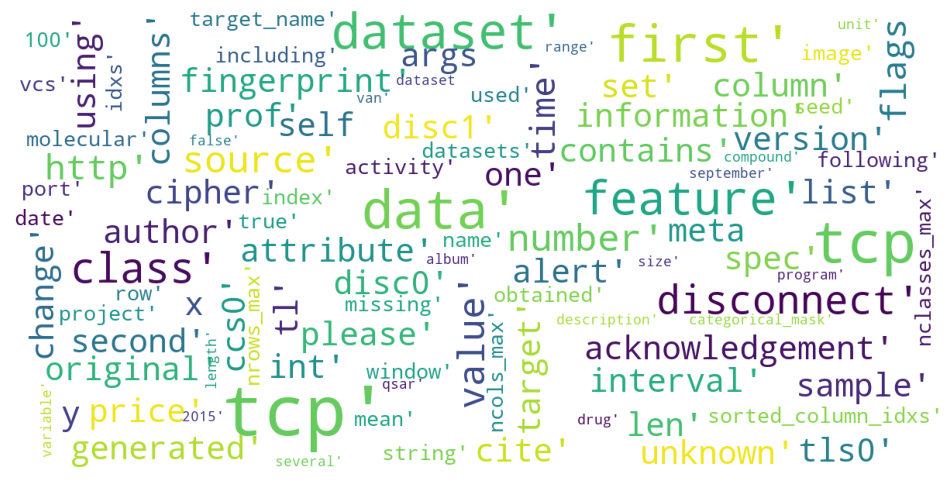

In [23]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        collocations=False,
        random_state=1)

    wordcloud = wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

## Named Entity Recognition (NER) with spaCy

Analyzing named entities in dataset descriptions to identify common entities like organizations, locations, dates, etc.

In [24]:
# Get the EntityRecognizer component from the pipeline
ner = nlp.get_pipe("ner")

# List the available entity types
entity_labels = ner.labels

print(entity_labels)

# Description for each entity type
for entity in entity_labels:
    print(f"{entity}: {spacy.explain(entity)}")

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')
CARDINAL: Numerals that do not fall under another type
DATE: Absolute or relative dates or periods
EVENT: Named hurricanes, battles, wars, sports events, etc.
FAC: Buildings, airports, highways, bridges, etc.
GPE: Countries, cities, states
LANGUAGE: Any named language
LAW: Named documents made into laws.
LOC: Non-GPE locations, mountain ranges, bodies of water
MONEY: Monetary values, including unit
NORP: Nationalities or religious or political groups
ORDINAL: "first", "second", etc.
ORG: Companies, agencies, institutions, etc.
PERCENT: Percentage, including "%"
PERSON: People, including fictional
PRODUCT: Objects, vehicles, foods, etc. (not services)
QUANTITY: Measurements, as of weight or distance
TIME: Times smaller than a day
WORK_OF_ART: Titles of books, songs, etc.


### Visualization of Named Entities

Visualizing named entities in a sample dataset description.


In [25]:
# Example visualization of entities in the description of the 500th dataset
doc = nlp(df['description'][500])

# Print detected entities
print(doc.ents)

# Visualize the entities
displacy.render(doc, style="ent")

(Friedman, 80, J.H. Friedman, 1999, Friedman, Friedman, 1999, Friedman, Friedman, Friedman, 5, 5, Friedman, 5 10 25 50 100, first, 5, 100 250 500, 4, 10, 25, 50, 100, 5, 10, 25, 50, 80, 4, 4, 5)


/Users/ivang/miniconda3/envs/openml-tags/lib/python3.11/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


### Named Entity Frequency Analysis

Counting the frequency of each entity type across all dataset descriptions.

In [26]:
# Perform NER on all descriptions
docs = [nlp(description) for description in tqdm(df['description'])]

# Count all named entities
entity_freq_counter = Counter([X.label_ for doc in docs for X in doc.ents])
entity_freq = entity_freq_counter.most_common()

# Plotting entity frequencies using Plotly
labels, values = zip(*entity_freq[::-1])  # Reverse for descending order in plot
entity_explanations = [spacy.explain(label) for label in labels]

# Generate the Plotly bar chart
fig = px.bar(x=values, y=labels, orientation='h', labels={'x': 'Count', 'y': 'Entity'},
             hover_data={'Entity': labels, 'Count': values, 'Description': entity_explanations})
fig.update_traces(hovertemplate='<b>Entity:</b> %{y}<br><b>Count:</b> %{x}<br><b>Description:</b> %{customdata[2]}')
fig.show()

100%|██████████| 5445/5445 [02:51<00:00, 31.78it/s] 


### Exploration of Most Common Entities

Investigating the most common entities for each entity type.

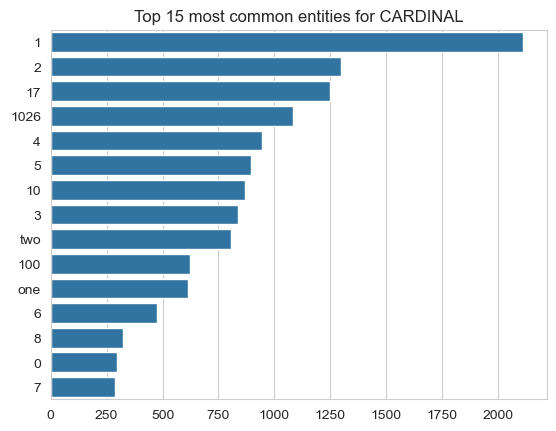

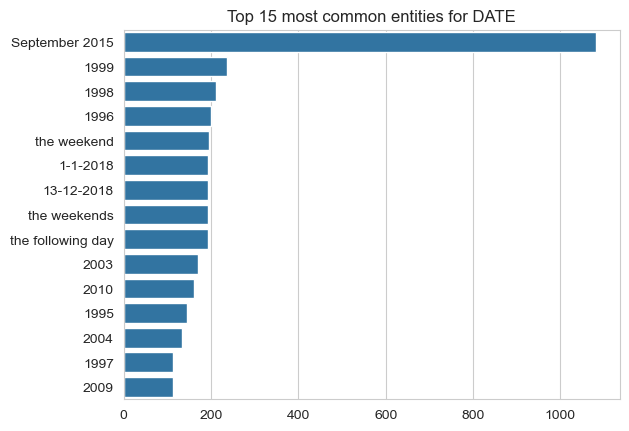

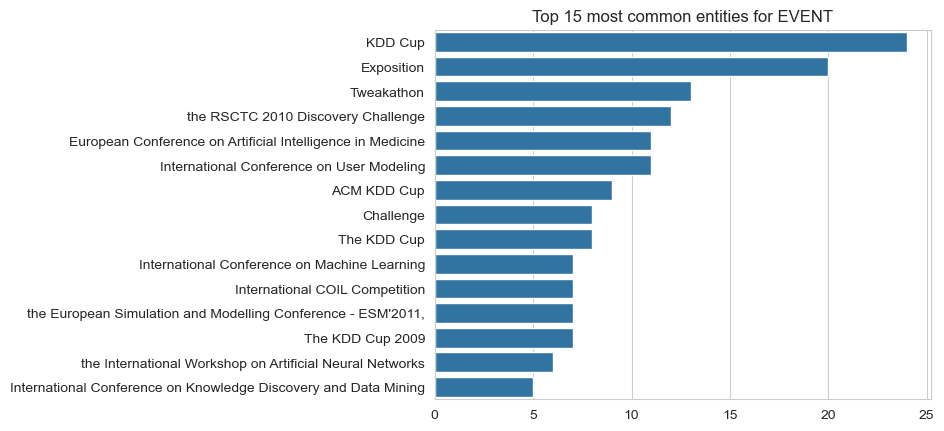

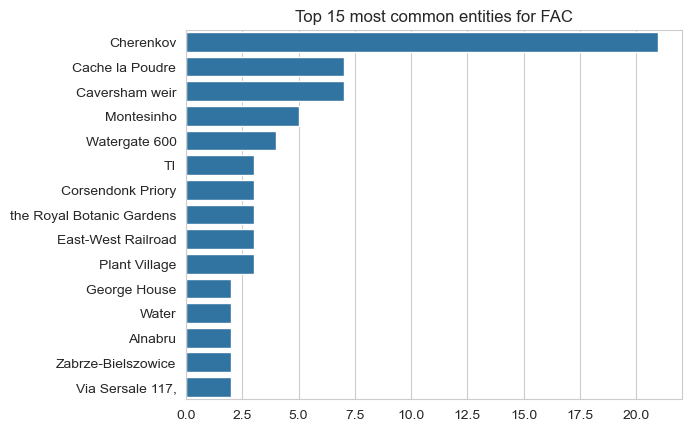

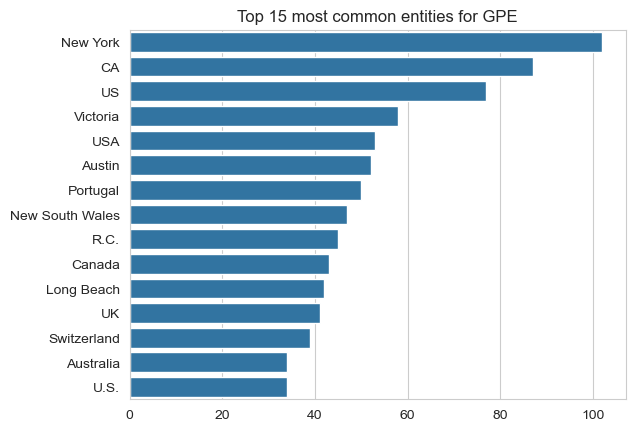

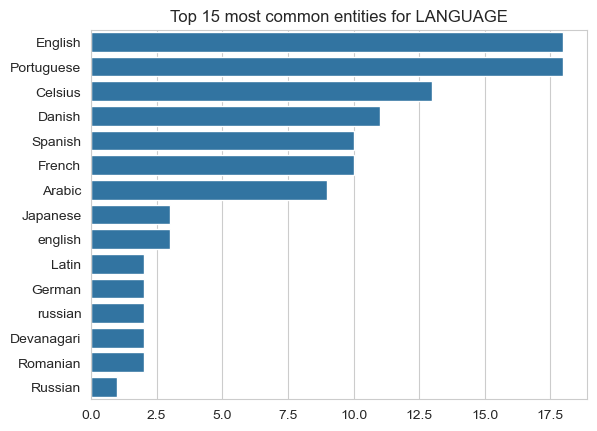

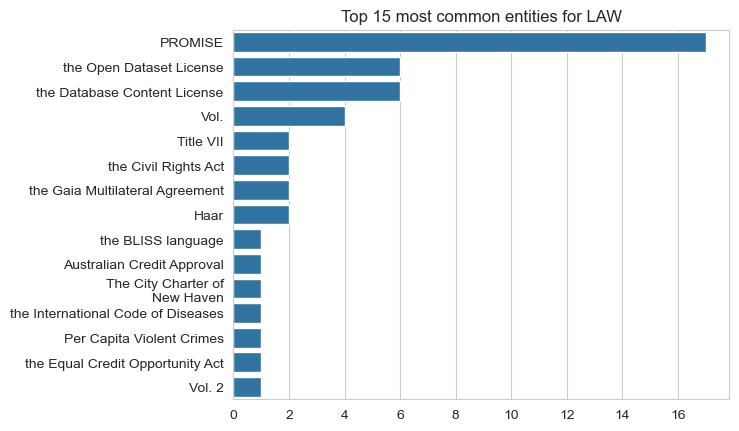

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 9 (	) missing from current font.



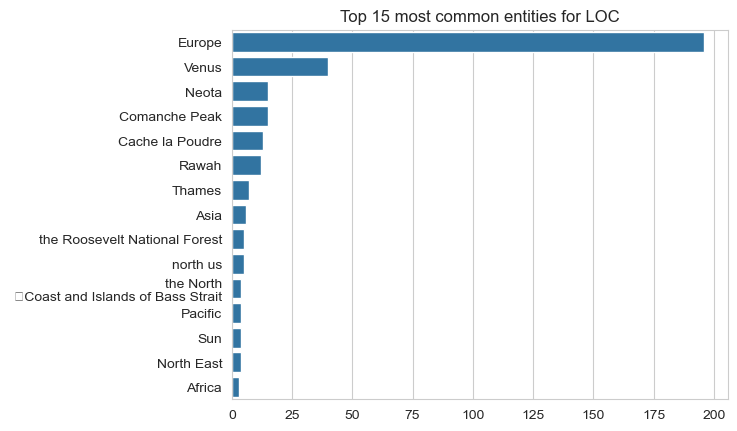

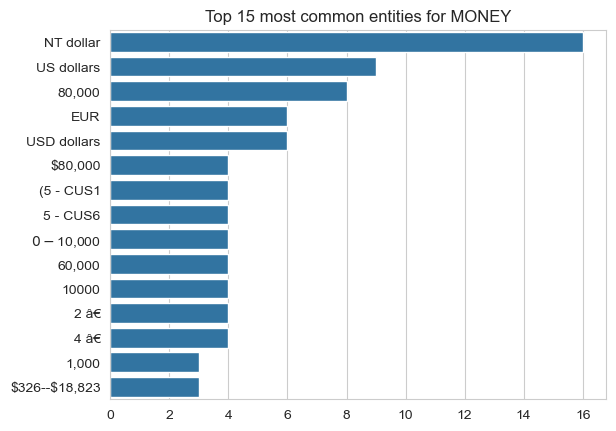

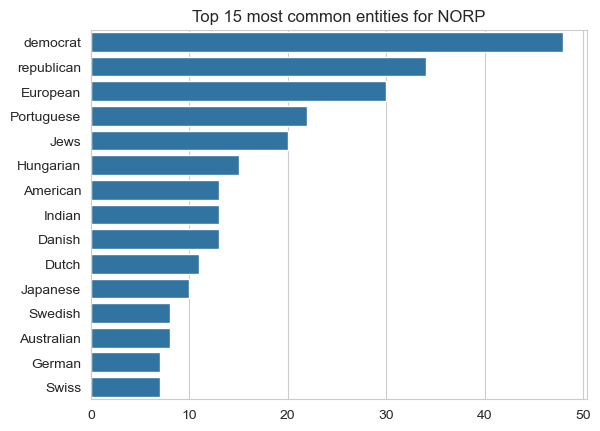

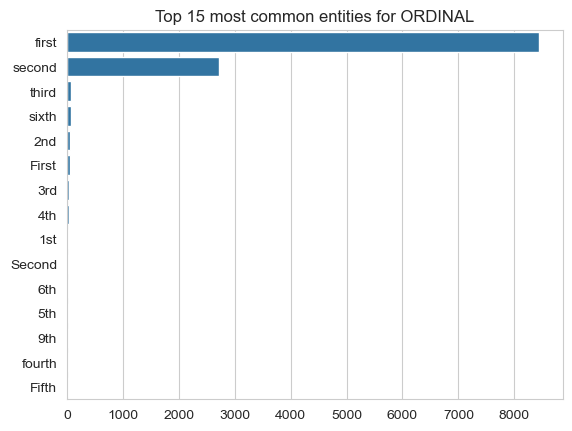

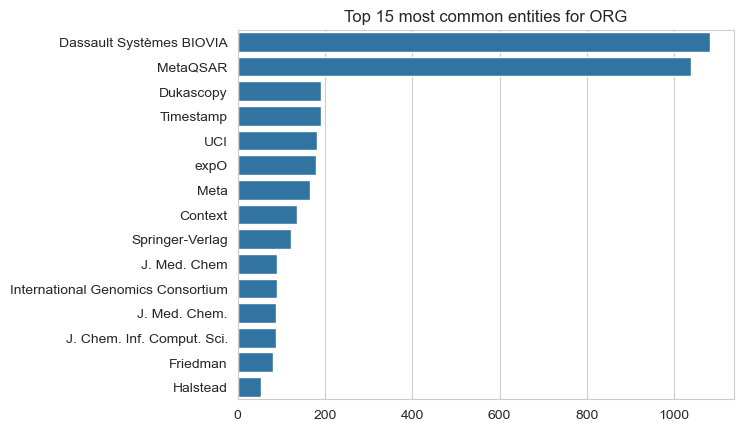

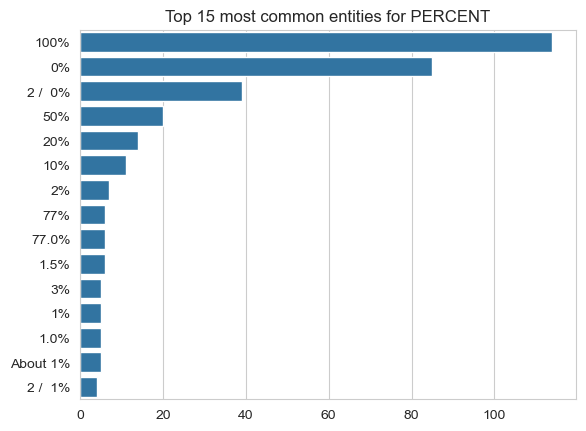

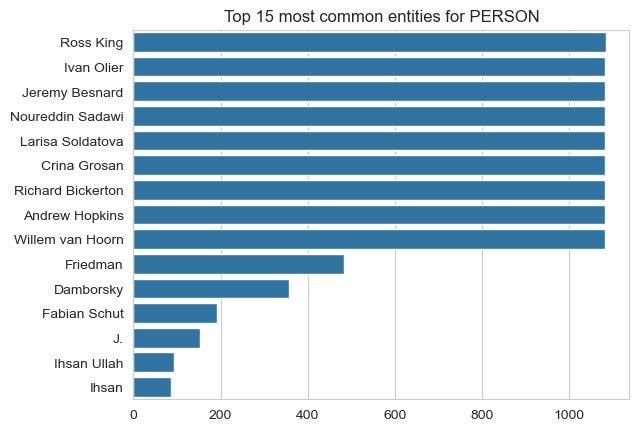

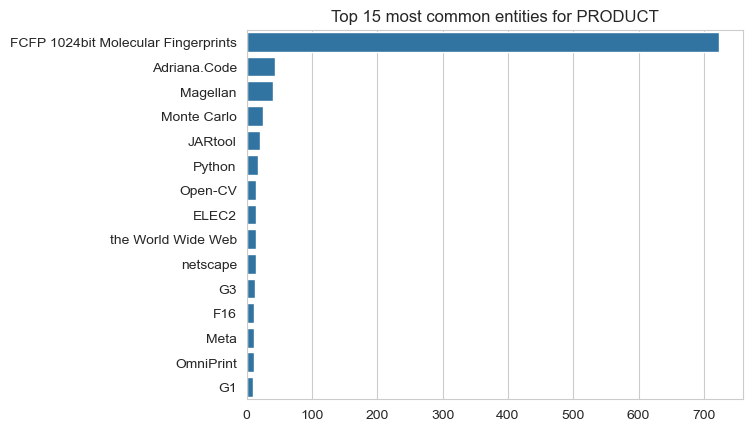

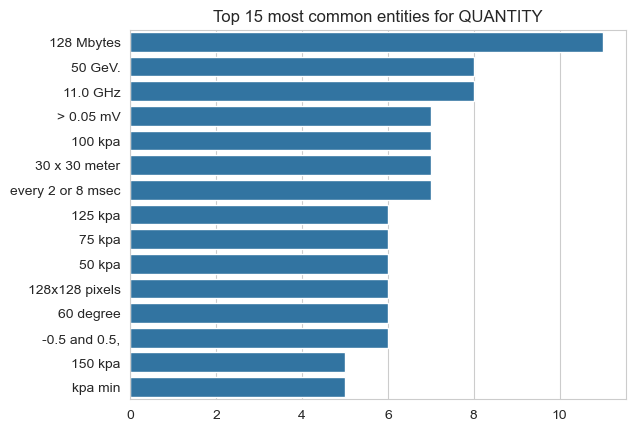

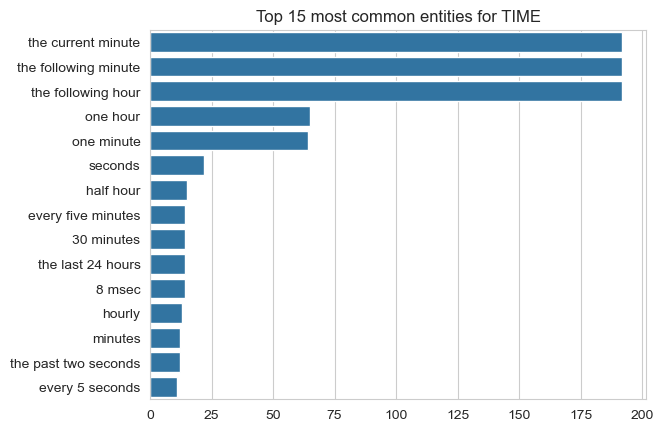

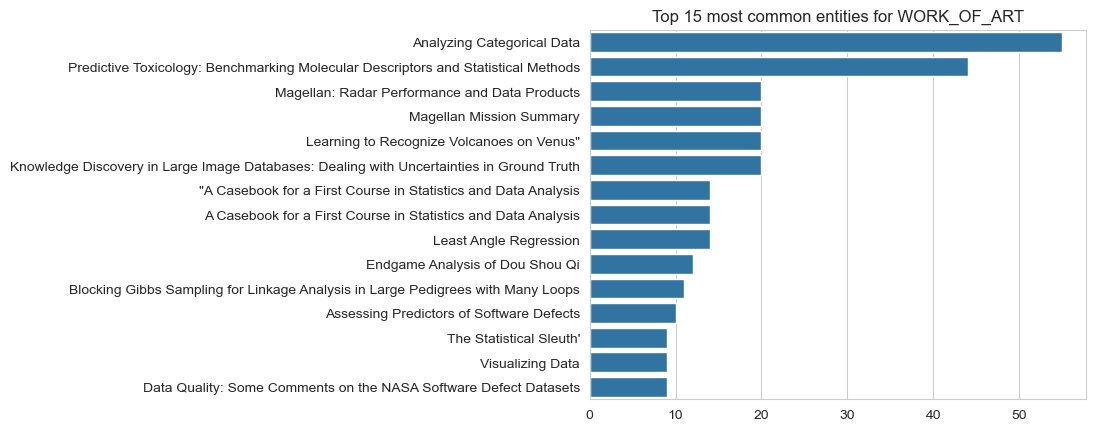

In [27]:
# Function to get the most common entities for a given label
def get_entities(label, most_common=10):
    entities = [X.text for doc in docs for X in doc.ents if X.label_ == label]
    return Counter(entities).most_common(most_common)

# Function to plot the most common entities for a given label
def plot_entities(label, k=15):
    entities = get_entities(label, k)
    entity_labels, entity_counts = zip(*entities)
    sns.barplot(x=list(entity_counts), y=list(entity_labels))
    plt.title(f'Top {k} most common entities for {label}')
    plt.show()

# Plot the most common entities for each label
for label in entity_labels:
    plot_entities(label)


## Part of Speech (POS) Tagging with spaCy

Analyzing the parts of speech in dataset descriptions to understand their grammatical composition.

In [28]:
# Example visualization of POS tags in the description of the 500th dataset 
doc = nlp(df['description'][500][:400])

options = {'distance': 75, 'compact': True, 'color': 'black', 'bg': '#f9e79f'}

# Visualize the entities
displacy.render(doc, style="dep", jupyter=True, options=options)

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.11/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [29]:
# Example POS tagging with explanations
for token in nlp('Can you give me the can, please?'):
    print(token.text, token.pos_, token.tag_, spacy.explain(token.tag_))

# Aggregate POS tagging for all descriptions
pos_freq_counter = Counter([X.pos_ for doc in docs for X in doc])
pos_freq = pos_freq_counter.most_common()

# Plotting POS frequencies using Plotly
labels, values = zip(*pos_freq[::-1])  # Reverse for descending order in plot
pos_explanations = [spacy.explain(label) for label in labels]

# Generate the Plotly bar chart
fig = px.bar(x=values, y=labels, orientation='h', labels={'x': 'Count', 'y': 'POS'},
             hover_data={'POS': labels, 'Count': values, 'Description': pos_explanations})
fig.update_traces(hovertemplate='<b>POS:</b> %{y}<br><b>Count:</b> %{x}<br><b>Description:</b> %{customdata[2]}')
fig.show()


Can AUX MD verb, modal auxiliary
you PRON PRP pronoun, personal
give VERB VB verb, base form
me PRON PRP pronoun, personal
the DET DT determiner
can NOUN NN noun, singular or mass
, PUNCT , punctuation mark, comma
please INTJ UH interjection
? PUNCT . punctuation mark, sentence closer


## Assessing Dataset Description Complexity

Evaluating the readability of dataset descriptions using the Flesch reading ease score.


### Readability Score Interpretation

The Flesch reading ease score is interpreted as follows:
- 90-100: Very easy to read, understood by an average 11-year-old student
- 80-90: Easy to read, conversational English for consumers
- 70-80: Fairly easy to read
- 60-70: Plain English, easily understood by 13- to 15-year-old students
- 50-60: Fairly difficult to read
- 30-50: Difficult to read
- 0-30: Very difficult to read, best understood by university graduates

<Axes: >

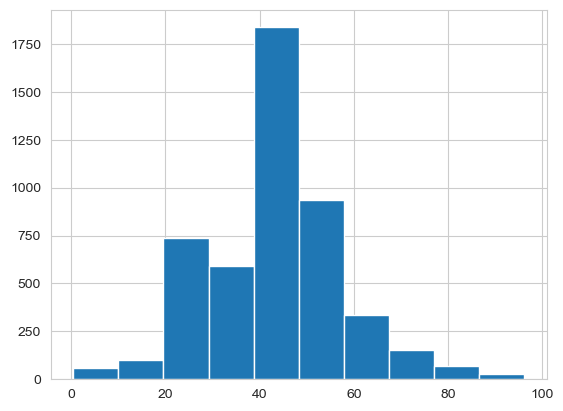

In [30]:
# Apply the Flesch reading ease test to each description, filter the ones with score below 0
stat = df['description'].apply(
    lambda x: textstat.textstat.flesch_reading_ease(x) if 0 < textstat.textstat.flesch_reading_ease(x) <= 100 else None)
stat.hist()

## Exploratory Data Analysis on Tags

We perform EDA on the 'tag' feature of datasets to better understand their categorization.


### Tag Presence Analysis

Comparing the number of datasets with and without tags.

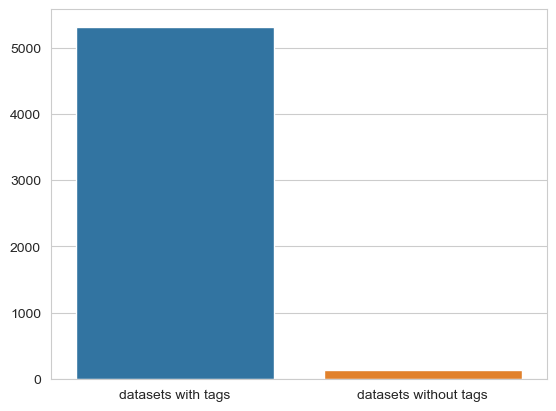

In [31]:
# Count datasets with and without tags
datasets_with_tags = df[df['tag'].notnull()]
datasets_without_tags = df[df['tag'].isnull()]

sns.barplot(x=['datasets with tags', 'datasets without tags'],
            y=[len(datasets_with_tags), len(datasets_without_tags)],
            hue=['datasets with tags', 'datasets without tags'])
plt.show()

### Tag Distribution Analysis

Analyzing the distribution of tags across datasets.

In [32]:
print(f"Average number of tags per dataset: {df['tag'].map(lambda x: len(x) if x else 0).mean()}")

Average number of tags per dataset: 4.368411386593205


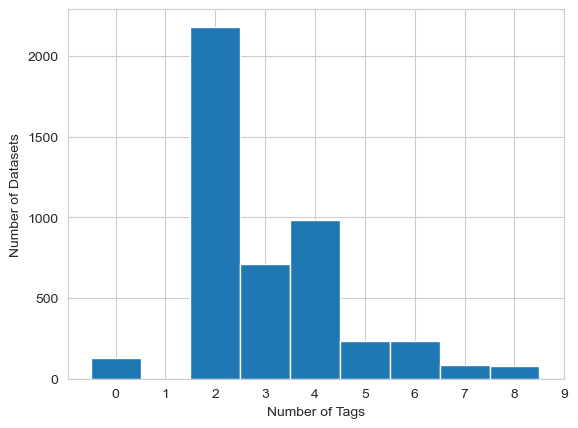

In [33]:
plt.hist(df['tag'].map(lambda x: len(x) if x else 0), bins=np.arange(0, 10) - 0.5)
plt.xlabel('Number of Tags')
plt.ylabel('Number of Datasets')
plt.xticks(range(10))
plt.show()

### Most Common Tags

Identifying the most common tags across all datasets.

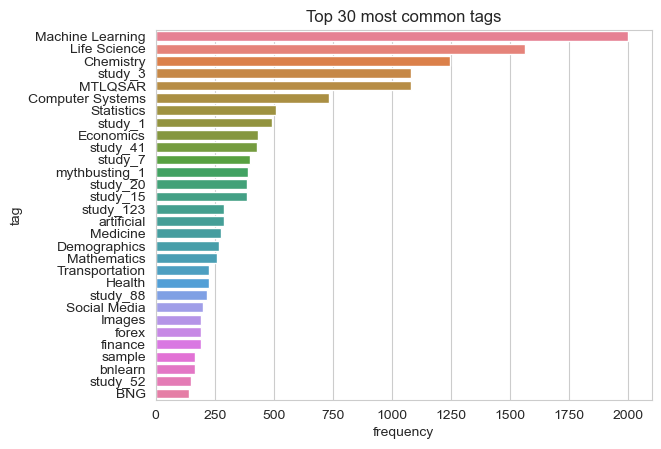

In [34]:
tags = df['tag'].dropna().map(lambda x: x if isinstance(x, list) else [x])
tags = [tag for sublist in tags for tag in sublist]
tag_freq = Counter(tags)
tag_freq = pd.DataFrame(sorted([(count, tag) for tag, count in tag_freq.items()], reverse=True))
tag_freq.columns = ['frequency', 'tag']

k = 30
sns.barplot(x=tag_freq['frequency'][:k], y=tag_freq['tag'][:k], hue=tag_freq['tag'][:k])
plt.title(f'Top {k} most common tags')
plt.show()

## Text Similarity Analysis

We analyze the similarity between dataset descriptions using TF-IDF and cosine similarity.


### Cosine Similarity Matrix

Generating a cosine similarity matrix for the dataset descriptions.

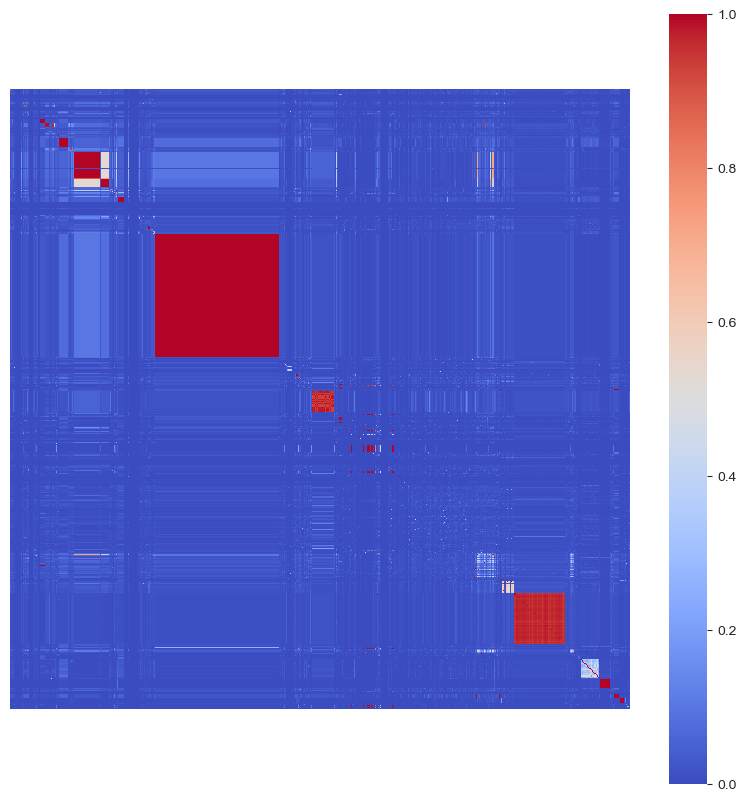

In [35]:
# Vectorize the descriptions
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['description'].map(clean))

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(X, X)

# Plot the similarity matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cosine_sim, cmap='coolwarm', square=True, xticklabels=False, yticklabels=False)
plt.show()

### Distribution of Cosine Similarities

Examining the distribution of similarity scores between different dataset descriptions.

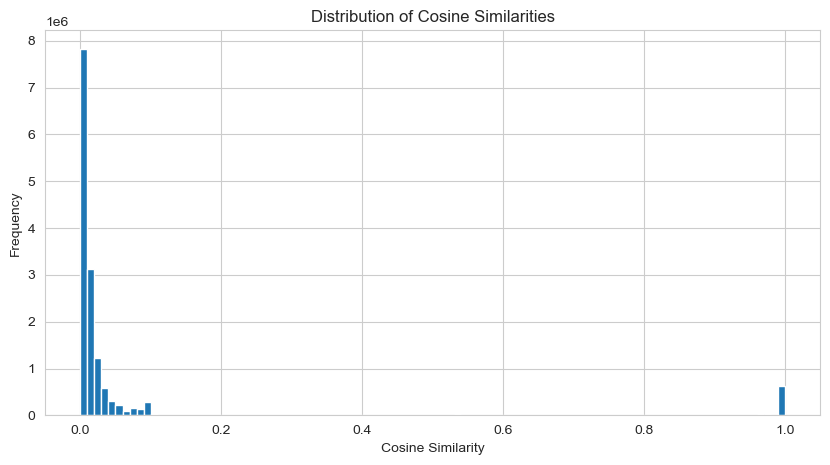

In [36]:
# Extract the upper triangle of the matrix, excluding the diagonal
upper_tri_idx = np.triu_indices_from(cosine_sim, k=1)
unique_similarities = cosine_sim[upper_tri_idx]

plt.figure(figsize=(10, 5))
plt.hist(unique_similarities, bins=100)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

### Similar Dataset Pairs

Filtering dataset pairs with a high level of similarity (cosine similarity > 0.9).

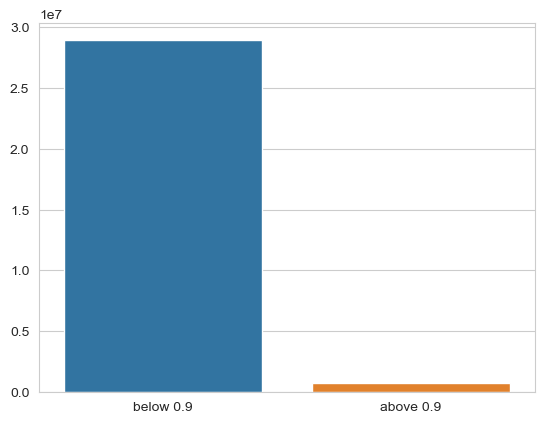

In [37]:
sns.barplot(x=['below 0.9', 'above 0.9'],
            y=[len(np.where(np.triu(cosine_sim, k=1) < 0.9)[0]), len(np.where(np.triu(cosine_sim, k=1) > 0.9)[0])],
            hue=['below 0.9', 'above 0.9'])
plt.show()

In [38]:
above_threshold_indices = np.where(np.triu(cosine_sim, k=1) > 0.9)

# Extract the dataset pairs based on the indices
similar_pairs = [(i, j, cosine_sim[i, j]) for i, j in zip(*above_threshold_indices)]

# Create a new DataFrame to store the similar dataset pairs with their similarity score
similar_df = pd.DataFrame(similar_pairs, columns=['Dataset_ID_1', 'Dataset_ID_2', 'Similarity'])

# Add dataset names, descriptions, openml_url, and version to the DataFrame for easier interpretation
similar_df['Dataset_Name_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['name'])
similar_df['Dataset_Description_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['description'])
similar_df['OpenML_URL_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['openml_url'])
similar_df['Version_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['version'])

similar_df['Dataset_Name_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['name'])
similar_df['Dataset_Description_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['description'])
similar_df['OpenML_URL_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['openml_url'])
similar_df['Version_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['version'])

similar_df

Dataset_ID_1  Dataset_ID_2  Similarity  \
0                  7           137    0.911781   
1                  7           142    0.906289   
2                 10            12    0.929122   
3                 16          2500    0.977177   
4                 24          4278    0.973543   
...              ...           ...         ...   
750557          5430          5431    0.934730   
750558          5434          5435    1.000000   
750559          5434          5436    1.000000   
750560          5435          5436    1.000000   
750561          5442          5443    1.000000   

                                        Dataset_Name_1  \
0                                                autos   
1                                                autos   
2                                        mfeat-factors   
3                                          mfeat-pixel   
4                                      credit-approval   
...                                                ...   
750557  padding-attack-dataset-netscalergcm-2023-12-13   
750558                                            test   
750559                                            test   
750560                                            test   
750561                                   HousingPrices   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [39]:
# Show an example of dataset pairs with high similarity 
similar_df[similar_df['Dataset_ID_1'] == 1287]

Dataset_ID_1  Dataset_ID_2  Similarity Dataset_Name_1  \
45870          1287          1288         1.0    QSAR-TID-11   
45871          1287          1289         1.0    QSAR-TID-11   
45872          1287          1290         1.0    QSAR-TID-11   
45873          1287          1291         1.0    QSAR-TID-11   
45874          1287          1292         1.0    QSAR-TID-11   
...             ...           ...         ...            ...   
46936          1287          2354         1.0    QSAR-TID-11   
46937          1287          2355         1.0    QSAR-TID-11   
46938          1287          2356         1.0    QSAR-TID-11   
46939          1287          2357         1.0    QSAR-TID-11   
46940          1287          2358         1.0    QSAR-TID-11   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Dataset_Description_1  \
45870  **Author**: Dr Ivan Olier, Dr Jeremy Besnard, Dr Noureddin Sadawi, Dr Larisa Soldatova, Dr Crina Grosan, Prof Ross King, Dr Richard Bickerton, Prof Andrew Hopkins and Dr Willem van Hoorn  \n**Source**: MetaQSAR project - September 2015  \n**Please cite**:   \n\nThis dataset contains QSAR data (from ChEMBL version 17) showing activity values (unit is pseudo-pCI50) of several compounds on drug target TID: 11, and it has 5742 rows and 1026 features (including IDs and class feature: MOLECULE_CHEMBL_ID and MEDIAN_PXC50). The features represent FCFP 1024bit Molecular Fingerprints which were generated from SMILES strings. They were obtained using the Pipeline Pilot program, Dassault Systèmes BIOVIA. Generating Fingerprints does not usually require missing value imputation as all bits are generated.   
45871  **Author**: Dr Ivan Olier, Dr Jeremy Besnard, Dr Noureddin Sadawi, Dr Larisa Soldatova, Dr Crina Grosan, Prof Ross King, Dr Richard Bickerton, Prof Andrew Hopkins and Dr Willem van Hoorn  \n**Source**: MetaQSAR project - September 2015  \n**Please cite**:   \n\nThis dataset contains QSAR data (from ChEMBL version 17) showing activity values (unit is pseudo-pCI50) of several compounds on drug target TID: 11, and it has 5742 rows and 1026 features (including IDs and class feature: MOLECULE_CHEMBL_ID and MEDIAN_PXC50). The features represent FCFP 1024bit Molecular Fingerprints which were generated from SMILES strings. They were obtained using the Pipeline Pilot program, Dassault Systèmes BIOVIA. Generating Fingerprints does not usually require missing value imputation as all bits are generated.   
45872  **Author**: Dr Ivan Olier, Dr Jeremy Besnard, Dr Noureddin Sadawi, Dr Larisa Soldatova, Dr Crina Grosan, Prof Ross King, Dr Richard Bickerton, Prof Andrew Hopkins and Dr Willem van Hoorn  \n**Source**: MetaQSAR project - September 2015  \n**Please cite**:   \n\nThis dataset contains QSAR data (from ChEMBL version 17) showing activity values (unit is pseudo-pCI50) of several compounds on drug target TID: 11, and it has 5742 rows and 1026 features (including IDs and class feature: MOLECULE_CHEMBL_ID and MEDIAN_PXC50). The features represent FCFP 1024bit Molecular Fingerprints which were generated from SMILES strings. They were obtained using the Pipeline Pilot program, Dassault Systèmes BIOVIA. Generating Fingerprints does not usually require missing value imputation as all bits are 

## Comparing Versions of Datasets

Investigating how dataset descriptions vary across different versions of the same dataset.

### Analysis of Similarity Between Different Dataset Versions

In [40]:
# Filter the similar_df for entries with the same name and different version (as before)
same_name_different_version = similar_df[
    (similar_df['Dataset_Name_1'] == similar_df['Dataset_Name_2']) &
    (similar_df['Version_1'] != similar_df['Version_2'])
    ]

# Filter the similar_df for entries that are not the same dataset (the complement)
not_same_dataset = similar_df[
    (similar_df['Dataset_Name_1'] != similar_df['Dataset_Name_2'])
]

In [41]:
same_name_different_version

Dataset_ID_1  Dataset_ID_2  Similarity Dataset_Name_1  \
3                 16          2500    0.977177    mfeat-pixel   
5                 26          4231    1.000000       credit-g   
8                 30          2504    0.919560        segment   
18                98          4081    0.991382    electricity   
19                98          4086    0.991665    electricity   
...              ...           ...         ...            ...   
750554          5418          5436    1.000000           test   
750558          5434          5435    1.000000           test   
750559          5434          5436    1.000000           test   
750560          5435          5436    1.000000           test   
750561          5442          5443    1.000000  HousingPrices   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Dataset_Description_1  \
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              **Author**: Robert P.W. Duin, Department of Applied Physics, Delft University of Technology  \n**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Multiple+Features) - 1998  \n**Please cite**: [UCI](h

In [42]:
not_same_dataset

Dataset_ID_1  Dataset_ID_2  Similarity  \
0                  7           137    0.911781   
1                  7           142    0.906289   
2                 10            12    0.929122   
4                 24          4278    0.973543   
6                 26          4232    1.000000   
...              ...           ...         ...   
750546          5401          5403    1.000000   
750547          5402          5403    1.000000   
750555          5429          5430    0.934730   
750556          5429          5431    0.934730   
750557          5430          5431    0.934730   

                                           Dataset_Name_1  \
0                                                   autos   
1                                                   autos   
2                                           mfeat-factors   
4                                         credit-approval   
6                                                credit-g   
...                                                   ...   
750546           3D_Estimation_using_RSSI_of_WLAN_dataset   
750547  3D_Estimation_using_RSSI_of_WLAN_dataset_complete   
750555         padding-attack-dataset-facebook-2023-12-05   
750556         padding-attack-dataset-facebook-2023-12-05   
750557     padding-attack-dataset-netscalergcm-2023-12-13   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

### Visualizing Similarity Distribution for Different Versions

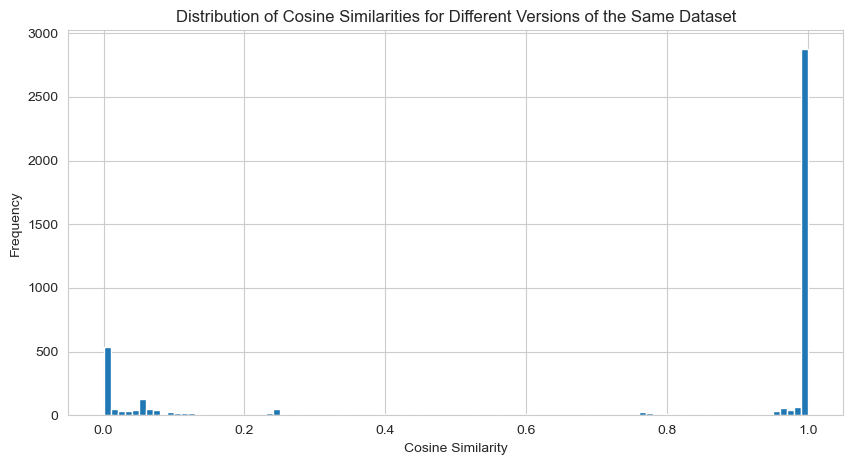

In [43]:
name_to_indices = defaultdict(list)
for i, row in df.iterrows():
    name_to_indices[row['name']].append(i)

version_similarity = []

for name, indices in name_to_indices.items():
    # Only consider names with more than one version
    if len(indices) > 1:
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                idx1, idx2 = indices[i], indices[j]
                similarity = cosine_sim[idx1, idx2]
                version_similarity.append({
                    'Dataset_Name': name,
                    'Version_1': df.iloc[idx1]['version'],
                    'OpenML_URL_1': df.iloc[idx1]['openml_url'],
                    'Version_2': df.iloc[idx2]['version'],
                    'OpenML_URL_2': df.iloc[idx2]['openml_url'],
                    'Similarity': similarity
                })

version_similarity_df = pd.DataFrame(version_similarity)

version_similarity_sorted = version_similarity_df.sort_values(by=['Dataset_Name', 'Similarity'],
                                                              ascending=[True, False])
plt.figure(figsize=(10, 5))
plt.hist(version_similarity_sorted['Similarity'], bins=100)

plt.title('Distribution of Cosine Similarities for Different Versions of the Same Dataset')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.show()

### Most Similar Dataset Versions

Identifying the most similar versions of datasets based on cosine similarity.

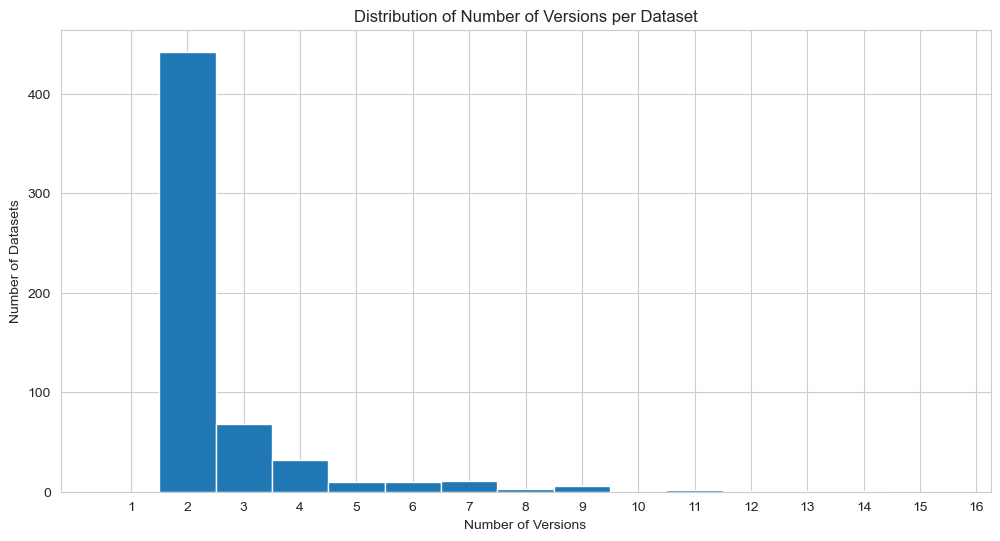

In [44]:
# Group by the 'name' column and count the number of versions for each dataset
version_counts = df.groupby('name').size()

# We're interested in datasets that have more than one version
multiple_versions = version_counts[version_counts > 1]

num_bins = min(multiple_versions.nunique(), 50)

plt.figure(figsize=(12, 6))
plt.hist(multiple_versions, bins=np.arange(1, num_bins + 1) - 0.5)

plt.title('Distribution of Number of Versions per Dataset')
plt.xlabel('Number of Versions')
plt.ylabel('Number of Datasets')

plt.xticks(range(1, num_bins + 1))
plt.show()

## Exploratory Data Analysis on Dataset Features

Analyzing the features of the datasets such as the number of features and their types.

### Distribution of Number of Features

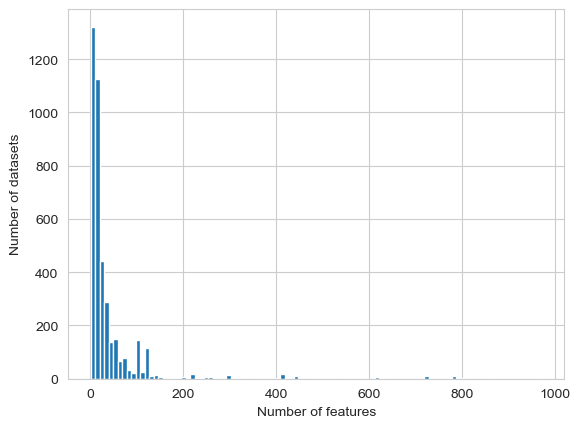

In [45]:
num_features = df._features.map(len)
plt.hist(num_features[num_features < 1000], bins=100, color='C0')
plt.xlabel('Number of features')
plt.ylabel('Number of datasets')
plt.show()

### Distribution of Number of Features with feature count > 1000 and > 2000

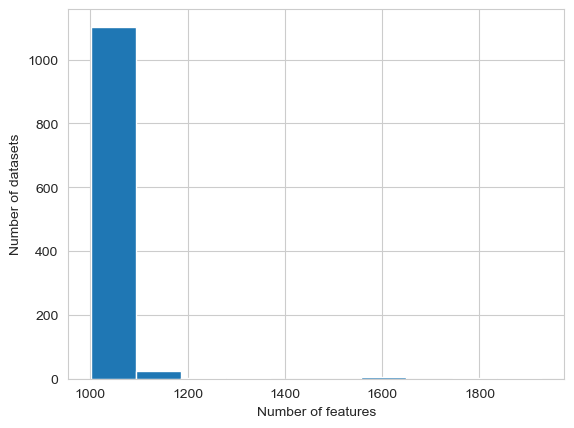

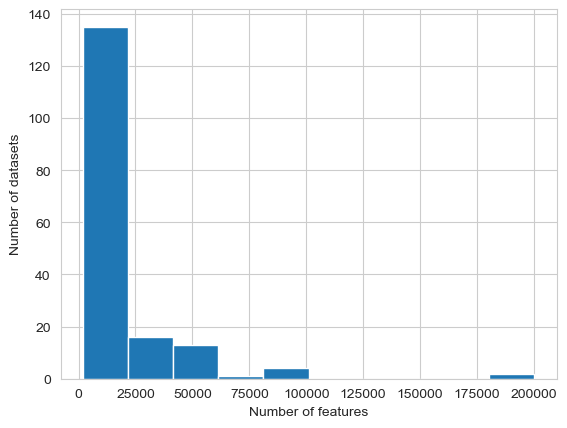

In [46]:
plt.hist(num_features[(num_features > 1000) & (num_features < 2000)], bins=10, color='C0')
plt.xlabel('Number of features')
plt.ylabel('Number of datasets')
plt.show()

plt.hist(num_features[(num_features > 2000)], bins=10, color='C0')
plt.xlabel('Number of features')
plt.ylabel('Number of datasets')
plt.show()

## Dataset Tags Analysis

Exploring the tags associated with the datasets to understand their categorization.

### POS Tagging and NER on Tags

In [47]:
# Combine all tags into one list and then into a text string for processing
tags = df['tag'].dropna().tolist()
tags_combined = ' '.join([' '.join(tag_list) for tag_list in tags if isinstance(tag_list, list)])

doc_tags = nlp(tags_combined)

# POS Tagging
pos_counts = Counter([token.pos_ for token in doc_tags])

# NER
ner_counts = Counter([ent.label_ for ent in doc_tags.ents])

# Convert the counts to DataFrames for easy plotting
df_pos_counts = pd.DataFrame(pos_counts.items(), columns=['POS', 'Frequency']).sort_values(by='Frequency',
                                                                                           ascending=True)
df_ner_counts = pd.DataFrame(ner_counts.items(), columns=['Entity', 'Frequency']).sort_values(by='Frequency',
                                                                                              ascending=True)

# Plotting POS tags using Plotly
fig_pos = px.bar(df_pos_counts, x='Frequency', y='POS', orientation='h', title='Frequency of POS Tags in Dataset Tags')
fig_pos.update_layout(xaxis_title='Frequency', yaxis_title='POS')
fig_pos.show()

# Plotting NER tags using Plotly
fig_ner = px.bar(df_ner_counts, x='Frequency', y='Entity', orientation='h',
                 title='Frequency of Named Entities in Dataset Tags')
fig_ner.update_layout(xaxis_title='Frequency', yaxis_title='Entity')
fig_ner.show()

## URL Analysis in Dataset Descriptions

Identifying and analyzing the presence of URLs in the dataset descriptions.

### Datasets with URLs

In [48]:
# Function to check if a description contains a URL
def contains_url(description):
    extractor = URLExtract()
    urls = extractor.find_urls(description)
    return bool(urls)

# Apply the function to each description and create a new column 'has_url'
# df['has_url'] = df['description'].fillna('').apply(contains_url)
# 
# # Filter the DataFrame to only include rows where 'has_url' is True
# datasets_with_urls = df[df['has_url']]
# 
# # Display these datasets
# datasets_with_urls

# same but without the 'has_url' column
datasets_with_urls = df[df['description'].apply(contains_url)]
datasets_with_urls

ignore_attribute  dataset_id  \
0                                         None           2   
1                                         None           3   
2                                         None           4   
3                                         None           5   
4                                         None           6   
...                                        ...         ...   
5391                                      None       45703   
5392                                      None       45704   
5393  [timestamp, cylinder_number, job_number]       45705   
5394              [timestamp, cylinder_number]       45706   
5395              [timestamp, cylinder_number]       45707   

                          name  version  \
0                       anneal        1   
1                     kr-vs-kp        1   
2                        labor        1   
3                   arrhythmia        1   
4                       letter        1   
...                        ...      ...   
5391  simulated_bank_marketing        5   
5392       simulated_covertype        6   
5393            cylinder-bands        4   
5394            cylinder-bands        5   
5395            cylinder-bands        6   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### Visualization of Datasets with URLs vs Datasets without URLs 

<Axes: >

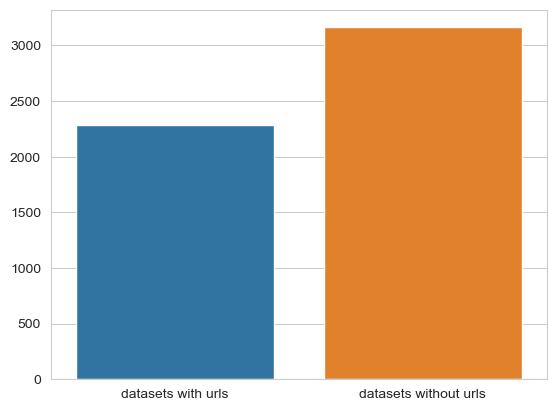

In [49]:
sns.barplot(x=['datasets with urls', 'datasets without urls'],
            y=[len(datasets_with_urls), len(df) - len(datasets_with_urls)],
            hue=['datasets with urls', 'datasets without urls'])

### Number of URLs in Dataset Descriptions

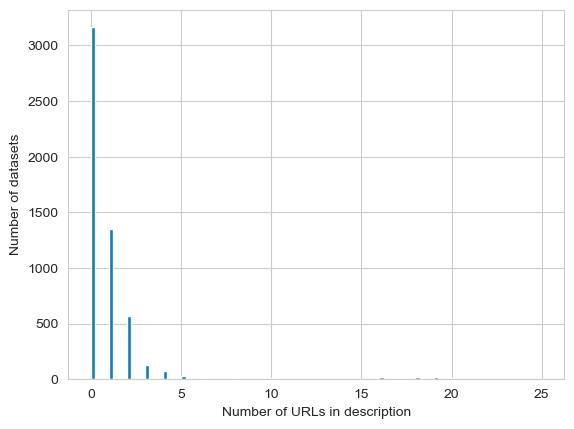

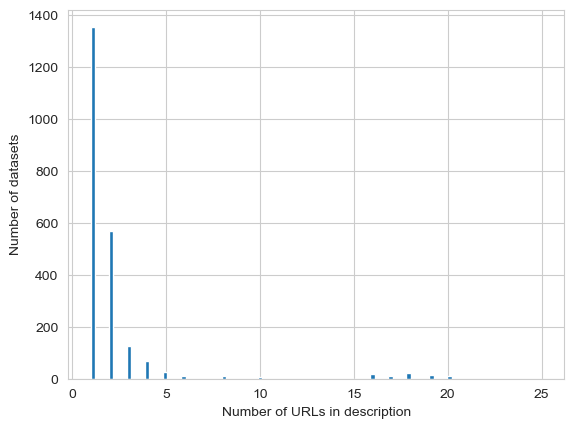

In [50]:
# Plot the number of URLs in dataset descriptions for all datasets
plt.hist(df['description'].apply(lambda x: len(URLExtract().find_urls(x))), bins=100, color='C0')
plt.xlabel('Number of URLs in description')
plt.ylabel('Number of datasets')
plt.show()

# Plot the number of URLs in dataset descriptions for datasets with URLs
plt.hist(datasets_with_urls['description'].apply(lambda x: len(URLExtract().find_urls(x))), bins=100, color='C0')
plt.xlabel('Number of URLs in description')
plt.ylabel('Number of datasets')
plt.show()

In [54]:
def extract_domain(description):
    # Find all URLs in the description
    extractor = URLExtract()
    urls = extractor.find_urls(description)
    domains = []
    for url in urls:
        # Prepend a scheme if missing
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url
        try:
            domain = urlparse(url).netloc
            if domain:
                domains.append(domain)
            else:
                print(f"Error: No domain found in URL: {url}")
        except ValueError as e:
            # If an invalid URL is found, log an error message
            print(f"ValueError: {str(e)} in URL: {url}")
    return domains

domains = datasets_with_urls['description'].apply(extract_domain)
domains

0       [archive.ics.uci.edu, archive.ics.uci.edu]
1       [archive.ics.uci.edu, archive.ics.uci.edu]
2                            [archive.ics.uci.edu]
3       [archive.ics.uci.edu, archive.ics.uci.edu]
4                            [archive.ics.uci.edu]
                           ...                    
5391                      [github.com, github.com]
5392                      [github.com, github.com]
5393    [archive.ics.uci.edu, archive.ics.uci.edu]
5394    [archive.ics.uci.edu, archive.ics.uci.edu]
5395    [archive.ics.uci.edu, archive.ics.uci.edu]
Name: description, Length: 2282, dtype: object

### Distribution of Domains

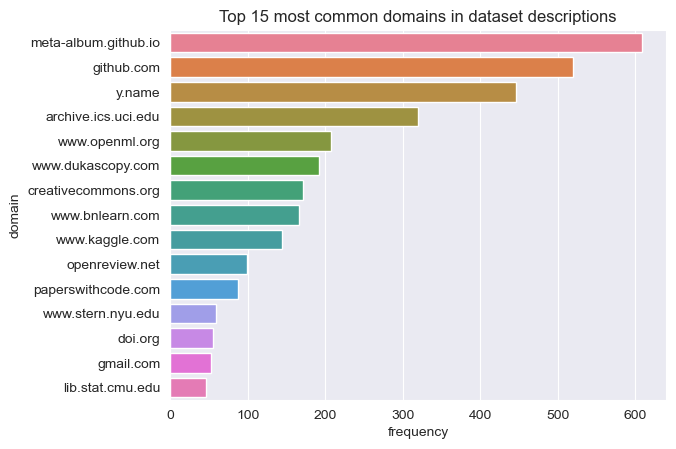

In [55]:
# Plot distribution of domains
sublists = [domain for sublist in domains for domain in sublist]
domain_freq = Counter(sublists)
domain_freq = pd.DataFrame(sorted([(count, domain) for domain, count in domain_freq.items()], reverse=True))
domain_freq.columns = ['frequency', 'domain']

k = 15
sns.barplot(x=domain_freq['frequency'][:k], y=domain_freq['domain'][:k], hue=domain_freq['domain'][:k])
plt.title(f'Top {k} most common domains in dataset descriptions')
plt.show()